<a href="https://colab.research.google.com/github/seokhee516/Default-Forecast-for-Thin-Filer-Project/blob/main/%EA%B8%88%EC%9C%B5%EA%B6%8C_%EB%8C%80%EC%B6%9C_%EC%83%81%ED%99%98_%EC%9D%B4%EC%A7%84%EB%B6%84%EB%A5%98_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 금융권 대출 상환 이진분류 예측


# 1. 데이터 설명


- `Lending Club 2007-2020Q3` **- Lending Club(렌딩 클럽)**은 미국 유명 **P2P 대출 업체** 입니다.
을 하고 있습니다.  캐글에서 제공하고 있는 데이터세트의 **2019년 데이터를 활용**하여 **2020년 상환상태를 예측**하였습니다.
- 캐글 주소 - [https://www.kaggle.com/datasets/ethon0426/lending-club-20072020q1](https://www.kaggle.com/datasets/ethon0426/lending-club-20072020q1)

# 2. EDA 및 데이터 전처리

## 2.1 데이터 및 모듈 불러오기

In [ ]:
import pandas as pd
import numpy as np
import pandas_profiling

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from scipy.stats import randint, uniform

from sklearn.model_selection import RandomizedSearchCV
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Integer, Categorical, Continuous
from sklearn_genetic.callbacks import DeltaThreshold, TimerStopping
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold


from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import shap

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 2.2 EDA 및 데이터 전처리

In [3]:
# 19년 ~ 20년 데이터 사용
sepc = df['issue_d']>='Sep-2019'
octc = (df['issue_d']>='Oct-2019') & (df['issue_d']<='Oct-2020')
novc = (df['issue_d']>='Nov-2019') & (df['issue_d']<='Nov-2020')
mayc = (df['issue_d']>='May-2019') & (df['issue_d']<='May-2020')
df = df[sepc | octc | novc | mayc].reset_index().iloc[:,2:]

In [4]:
# loan_status 변수를 정상(0)과 불량(1)으로 이진 분류하여 Target 변수 생성
df.loc[(df['loan_status']== 'Fully Paid')|(df['loan_status']== 'Current'),"Target"]= 0 # 정상(0)
df.loc[(df['loan_status']== 'Late (31-120 days)')|(df['loan_status']== 'Charged Off')|
       (df['loan_status']== 'In Grace Period')|(df['loan_status']== 'Late (16-30 days)')|
       (df['loan_status']== 'Default')|(df['loan_status']== 'Issued')|
       (df['loan_status']== 'Late (31-120 days)'),'Target'] = 1 # 불량(1)

In [5]:
# 141 특성 중 30개만 사용
columns = ['annual_inc', 'inq_last_6mths', 'home_ownership','purpose', 'last_fico_range_high', 'last_fico_range_low',
           'sub_grade', 'int_rate', 'installment','tot_cur_bal', 'avg_cur_bal', 
           'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 
           'mort_acc', 'num_il_tl', 'emp_length', 'num_tl_op_past_12m', 'revol_bal',
           'total_bc_limit', 'dti', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
           'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'tot_hi_cred_lim',
           'Target', 'issue_d'] # id, Target, issue_d: Date
df = df[columns]
df = df.dropna()

In [6]:
df.reset_index(inplace=True)
df.rename(columns = {'index':'id'},inplace=True)

In [11]:
df.head()

,id,annual_inc,inq_last_6mths,home_ownership,purpose,last_fico_range_high,last_fico_range_low,sub_grade,int_rate,installment,...,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,tot_hi_cred_lim,Target,issue_d
0,0,45000.0,0.0,MORTGAGE,debt_consolidation,754.0,750.0,C4,16.40%,393.73,...,0.00,0.00,18366.63,18366.63,16050.00,2316.63,0.0,236274.0,0.0,May-2019
1,2,60000.0,0.0,MORTGAGE,other,759.0,755.0,A3,7.56%,93.41,...,2157.43,2157.43,1024.99,1024.99,842.57,182.42,0.0,51719.0,0.0,May-2019
2,3,90000.0,1.0,MORTGAGE,credit_card,664.0,660.0,C1,13.90%,494.88,...,11509.65,11509.65,4431.53,4431.53,2990.35,1441.18,0.0,186397.0,0.0,May-2019
3,4,92600.0,2.0,MORTGAGE,credit_card,679.0,675.0,B5,13.08%,569.86,...,21646.04,21646.04,6232.13,6232.13,3353.96,2878.17,0.0,228880.0,0.0,May-2019
4,5,100000.0,0.0,OWN,debt_consolidation,669.0,665.0,C3,15.57%,614.91,...,21752.04,21752.04,7334.76,7334.76,3772.96,3561.80,0.0,293750.0,0.0,May-2019


<AxesSubplot:xlabel='Target', ylabel='count'>

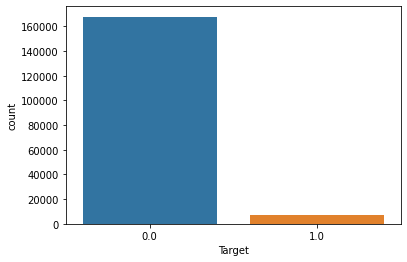

In [ ]:
# 타겟 분포확인 O: 정상, 1: 불량 (불균형)
sns.countplot(x = df['Target'])

In [ ]:
# test set 만들기
test = df[(df['issue_d'] == 'Sep-2020') | (df['issue_d'] == 'May-2020')]
train = df.drop(test.index)

# validation set 만들기
train, val = train_test_split(train, train_size = 0.8, stratify=train['Target'], random_state=10)

In [ ]:
def engineer(df):
    df = df.copy()

    # emp_length 범주형 변수 차원 증가 방지를 위해 범주군으로 묶음
    df.loc[(df['emp_length']== '< 1 year')|(df['emp_length']== '1 year')|
           (df['emp_length']== '2 years')|(df['emp_length']== '3 years'),'emp_length'] = 'less than 3 years'
    df.loc[(df['emp_length']== '4 years')|(df['emp_length']== '5 years')|
           (df['emp_length']== '6 years')|(df['emp_length']== '7 years')|
           (df['emp_length']== '8 years')|(df['emp_length']== '9 years'),'emp_length'] = 'more than 4 years and less than 9 years'
    df['emp_length'].fillna('unemployed', inplace=True)

    # purpose 범주형 변수 차원 증가 방지를 위해 범주군으로 묶음
    df.loc[(df['purpose']== 'car')|(df['purpose']== 'home_improvement')|
           (df['purpose']== 'house')|(df['purpose']== 'major_purchase')|
       (df['purpose']== 'medical')|(df['purpose']== 'moving')|
       (df['purpose']== 'other')|(df['purpose']== 'renewable_energy')|
       (df['purpose']== 'small_business')|(df['purpose']== 'vacation')|(df['purpose']== 'wedding'),'purpose'] = 'General loan debt'
    # int_rate % 기호를 제거하고 수치형으로 변환
    df['int_rate'] = df['int_rate'].replace('%','', regex=True).apply(pd.to_numeric)

    # sub_grade 수치형으로 변환
    sub_grade_ranks = {'A1': 1.1, 'A2': 1.2, 'A3': 1.3, 'A4': 1.4, 'A5': 1.5, 
                       'B1': 2.1, 'B2': 2.2, 'B3': 2.3, 'B4': 2.4, 'B5': 2.5, 
                       'C1': 3.1, 'C2': 3.2, 'C3': 3.3, 'C4': 3.4, 'C5': 3.5, 
                       'D1': 4.1, 'D2': 4.2, 'D3': 4.3, 'D4': 4.4, 'D5': 4.5}
    df['sub_grade'] = df['sub_grade'].map(sub_grade_ranks)


    # Reset index
    df = df.reset_index(drop=True)

    return df
train = engineer(train)
val = engineer(val)
test = engineer(test)

In [ ]:
features = train.drop(columns=['Target']).columns

X_train = train[features]
y_train = train['Target']
X_val = val[features]
y_val = val['Target']
X_test = test[features]
y_test = test['Target']

print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

In [ ]:
# test ids를 저장하고 SHAP분석시 사용
test_id = X_test['id']

# 3. 모델링

In [ ]:
# 평가지표 함수
def model_evaluation(label, predict):
    cf_matrix = confusion_matrix(label, predict)
    Accuracy = (cf_matrix[0][0] + cf_matrix[1][1]) / sum(sum(cf_matrix))
    Precision = cf_matrix[1][1] / (cf_matrix[1][1] + cf_matrix[0][1])
    Recall = cf_matrix[1][1] / (cf_matrix[1][1] + cf_matrix[1][0])
    F1_Score = (2 * Recall * Precision) / (Recall + Precision)
    print("Model_Evaluation with Label: 1")
    print("Accuracy: {:.1%}".format(Accuracy))
    print("Precision: {:.1%}".format(Precision))
    print("Recall: {:.1%}".format(Recall))
    print("F1-Score: {:.1%}".format(F1_Score))

## 3.1 기준모델

In [ ]:
# Baseline
# 기준모델 검증세트
major = y_train.mode()[0]
y_val = val['Target']
y_val_pred = [major] * len(y_val)
print("기준모델 검증세트 평가")
model_evaluation(y_val, y_val_pred)

기준모델 검증세트 평가
Model_Evaluation with Label: 1
Accuracy: 96.6%
Precision: nan%
Recall: 0.0%
F1-Score: nan%


In [ ]:
y_test = test['Target']
y_test_pred = [major] * len(y_test)
print("기준모델 테스트세트 평가")
model_evaluation(y_test, y_test_pred)

기준모델 테스트세트 평가
Model_Evaluation with Label: 1
Accuracy: 89.3%
Precision: nan%
Recall: 0.0%
F1-Score: nan%


## 3.2 클래스 불균형 조절 (Oversanpling)

In [ ]:
# 데이터 프로세싱
processor = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean')
)
X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)
X_test_processed = processor.transform(X_test)

# SMOTE를 이용한 Oversampling 후 모델링
sm = SMOTE(random_state = 10, sampling_strategy=0.5)
X_train_res, y_train_res = sm.fit_resample(X_train_processed, y_train.ravel())


OverSampling 전, '불량(1)' 라벨의 수: 4420
OverSampling 전, '정상(0)' 라벨의 수: 124437



<AxesSubplot:xlabel='Target', ylabel='count'>

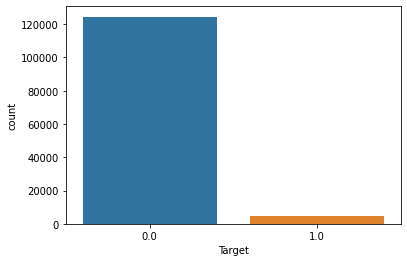

In [ ]:
print("OverSampling 전, '불량(1)' 라벨의 수: {}".format(sum(y_train == 1)))
print("OverSampling 전, '정상(0)' 라벨의 수: {}\n".format(sum(y_train == 0)))
sns.countplot(x = y_train)

OverSampling 후, '불량(1)' 라벨의 수: 62218
OverSampling 후, '정상(0)' 라벨의 수: 124437


<AxesSubplot:ylabel='count'>

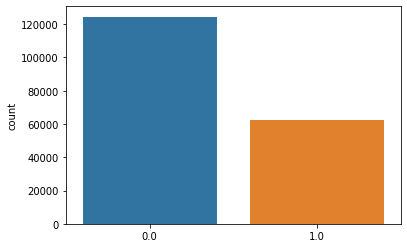

In [ ]:
print("OverSampling 후, '불량(1)' 라벨의 수: {}".format(sum(y_train_res == 1)))
print("OverSampling 후, '정상(0)' 라벨의 수: {}".format(sum(y_train_res == 0)))
sns.countplot(x = y_train_res)

In [ ]:
# X_val과 X_test도 Oversampling 진행
X_val_res, y_val_res = sm.fit_resample(X_val_processed, y_val.ravel())
X_test_res, y_test_res = sm.fit_resample(X_test_processed, y_test.ravel())

## 3.3 Logistic Regression


In [ ]:
# Logistic Regression
lr_pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(random_state=10, n_jobs=-1,
                       class_weight='balanced',
                       max_iter=1000, solver='saga', penalty = 'l1')
)
lr_pipe.fit(X_train, y_train);
y_pred_lr_pipe = lr_pipe.predict(X_val)
print("로지스틱 검증세트 평가")
model_evaluation(y_val, y_pred_lr_pipe)
y_test_pred_lr_pipe = lr_pipe.predict(X_test)
print("로지스틱 테스트세트 평가")
model_evaluation(y_test, y_test_pred_lr_pipe)

In [ ]:
# Logistic Regression Oversampling
lr_pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(random_state=10, n_jobs=-1,
                       class_weight='balanced',
                       max_iter=1000)
)
lr_pipe.fit(X_train_res, y_train_res);
y_res_pred_lr_pipe = lr_pipe.predict(X_val_res)
print("로지스틱 검증세트 평가")
model_evaluation(y_val_res, y_res_pred_lr_pipe)

In [ ]:
y_test_res_pred_lr_pipe = lr_pipe.predict(X_test_res)
print("로지스틱 테스트세트 평가")
model_evaluation(y_test_res, y_test_res_pred_lr_pipe)

## 3.3 DecisionTree

In [ ]:
# DecisionTreeClassifier
dt_pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(random_state=10, 
                           class_weight='balanced')
)
param_distributions = { 
    'decisiontreeclassifier__max_depth': [5, 7, 9, 12, 15], 
    'decisiontreeclassifier__min_samples_leaf': randint(2, 20),
    'decisiontreeclassifier__min_samples_split': randint(2, 20) 
}

search = RandomizedSearchCV(
    dt_pipe, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='f1', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=10
)
search.fit(X_train, y_train);
dt_model = search.best_estimator_
y_pred_dt = dt_model.predict(X_val)
print("결정트리 검증세트 평가")
model_evaluation(y_val,y_pred_dt)

y_pred_dt_test = dt_model.predict(X_test)
print("결정트리 테스트세트 평가")
model_evaluation(y_test,y_pred_dt_test)

In [ ]:
# DecisionTreeClassifier Oversampling
dt_pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(random_state=10, 
                           class_weight='balanced')
)
param_distributions = { 
    'decisiontreeclassifier__max_depth': [5, 7, 9, 12, 15], 
    'decisiontreeclassifier__min_samples_leaf': randint(2, 20),
    'decisiontreeclassifier__min_samples_split': randint(2, 20) 
}

search = RandomizedSearchCV(
    dt_pipe, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='f1', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=10
)
search.fit(X_train_res, y_train_res);
dt_model2 = search.best_estimator_

y_pred_dt_res = dt_model2.predict(X_val_res)
print("결정트리 검증세트 평가")
model_evaluation(y_val_res,y_pred_dt_res)

y_pred_dt_test_res = dt_model2.predict(X_test_res)
print("결정트리 테스트세트 평가")
model_evaluation(y_test_res,y_pred_dt_test_res)

## 3.5 RandomForest

In [ ]:
# RandomForestClassifier
rf_pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=42, n_jobs=-1,
                           class_weight='balanced')
)
param_distributions = { 
    'randomforestclassifier__n_estimators': randint(50, 800), 
    'randomforestclassifier__max_depth': [5, 7, 9, 12, 15], 
    'randomforestclassifier__min_samples_leaf': randint(2, 20),
    'randomforestclassifier__min_samples_split': randint(2, 20) 
}

search = RandomizedSearchCV(
    rf_pipe, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='f1', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=10
)
search.fit(X_train, y_train);
rf_model = search.best_estimator_

y_pred_rf = rf_model.predict(X_val)
print("랜덤포레스트 검증세트 평가")
model_evaluation(y_val,y_pred_rf)

y_pred_rf_test = rf_model.predict(X_test)
print("랜덤포레스트 테스트세트 평가")
model_evaluation(y_test,y_pred_rf_test)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
랜덤포레스트 검증세트 평가
Model_Evaluation with Label: 1
Accuracy: 97.2%
Precision: 57.4%
Recall: 70.6%
F1-Score: 63.3%
랜덤포레스트 테스트세트 평가
Model_Evaluation with Label: 1
Accuracy: 58.5%
Precision: 20.3%
Recall: 98.4%
F1-Score: 33.6%


In [ ]:
# RandomForestClassifier Oversampling
rf_pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=42, n_jobs=-1,
                           class_weight='balanced')
)
param_distributions = { 
    'randomforestclassifier__n_estimators': randint(50, 800), 
    'randomforestclassifier__max_depth': [5, 7, 9, 12, 15], 
    'randomforestclassifier__min_samples_leaf': randint(2, 20),
    'randomforestclassifier__min_samples_split': randint(2, 20) 
}

search = RandomizedSearchCV(
    rf_pipe, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='f1', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=10
)
search.fit(X_train_res, y_train_res);
rf_model2 = search.best_estimator_

y_pred_rf_res = rf_model2.predict(X_val_res)
print("랜덤포레스트 검증세트 평가")
model_evaluation(y_val_res,y_pred_rf_res)

y_pred_rf_test_res = rf_model2.predict(X_test_res)
print("랜덤포레스트 테스트세트 평가")
model_evaluation(y_test_res, y_pred_rf_test_res)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
랜덤포레스트 검증세트 평가
Model_Evaluation with Label: 1
Accuracy: 96.4%
Precision: 95.0%
Recall: 94.3%
F1-Score: 94.6%
랜덤포레스트 테스트세트 평가
Model_Evaluation with Label: 1
Accuracy: 90.3%
Precision: 79.1%
Recall: 96.3%
F1-Score: 86.8%


## 3.6 XGBoost

In [ ]:
## XGBClassifier
xgb_pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBClassifier(random_state=10, n_jobs=-1, silent=1,
                   class_weight='balanced')
)
param_distributions = { 
    'xgbclassifier__n_estimators': randint(50, 1000), 
    'xgbclassifier__max_depth': [5, 6, 7, 8, 9, 10], 
    'xgbclassifier__ min_child_weight ': randint(1, 10)
}

search = RandomizedSearchCV(
    xgb_pipe, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='f1', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=10
)
search.fit(X_train, y_train);

xgb_model = search.best_estimator_
y_pred_xgb = xgb_model.predict(X_val)
print("XGB 검증세트 평가")
model_evaluation(y_val,y_pred_xgb)

y_pred_xgb_test = xgb_model.predict(X_test)
print("XGB 테스트세트 평가")
model_evaluation(y_test,y_pred_xgb_test)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [ ]:
## XGBClassifier Oversamplig
xgb_pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBClassifier(random_state=10, n_jobs=-1, silent=1,
                   class_weight='balanced')
)
param_distributions = { 
    'xgbclassifier__n_estimators': randint(50, 1000), 
    'xgbclassifier__max_depth': [5, 6, 7, 8, 9, 10], 
    'xgbclassifier__ min_child_weight ': randint(1, 10),
    'xgbclassifier__booster' : ["gbtree’", "dart", "gblinear"]
}

search = RandomizedSearchCV(
    xgb_pipe, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='f1', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=10
)
search.fit(X_train_res, y_train_res);
xgb_model2 = search.best_estimator_

y_pred_xgb2_res = xgb_model2.predict(X_val_res)
print("XGB 검증세트 평가")
model_evaluation(y_val_res,y_pred_xgb2_res)

y_pred_xgb2_test_res = xgb_model2.predict(X_test_res)
print("XGB 테스트세트 평가")
model_evaluation(y_test_res,y_pred_xgb2_test_res)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
XGB 검증세트 평가
Model_Evaluation with Label: 1
Accuracy: 98.1%
Precision: 98.8%
Recall: 95.4%
F1-Score: 97.1%
XGB 테스트세트 평가
Model_Evaluation with Label: 1
Accuracy: 88.7%
Precision: 76.0%
Recall: 96.7%
F1-Score: 85.1%


## 3.7 LightGBM


In [ ]:
## LGBMClassifier
lgb_pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    LGBMClassifier(random_state=42, n_jobs=-1,
                   class_weight='balanced')
)
param_distributions = { 
    'lgbmclassifier__n_estimators': randint(50, 1000), 
    'lgbmclassifier__max_depth': [5, 7, 10, 12, 15], 
    'lgbmclassifier__num_leaves': randint(31, 100),
    'lgbmclassifier__boosting_type' : ["gbdt’", "dart", "rf"]
}

search = RandomizedSearchCV(
    lgb_pipe, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='f1', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=10
)
search.fit(X_train, y_train);
lgb_model = search.best_estimator_
y_pred_lgb = lgb_model.predict(X_val)

print("LGBM 검증세트 평가")
model_evaluation(y_val,y_pred_lgb)

y_pred_lgb_test = lgb_model.predict(X_test)
print("LGBM 테스트세트 평가")
model_evaluation(y_test,y_pred_lgb_test)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
LGBM 검증세트 평가
Model_Evaluation with Label: 1
Accuracy: 97.3%
Precision: 58.6%
Recall: 74.3%
F1-Score: 65.5%
LGBM 테스트세트 평가
Model_Evaluation with Label: 1
Accuracy: 39.1%
Precision: 14.0%
Recall: 91.4%
F1-Score: 24.3%


In [ ]:
## LGBMClassifier Oversamplig
lgb_pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    LGBMClassifier(random_state=42, n_jobs=-1,
                   class_weight='balanced')
)
param_distributions = { 
    'lgbmclassifier__n_estimators': randint(50, 1000), 
    'lgbmclassifier__max_depth': [5, 7, 10, 12, 15], 
    'lgbmclassifier__num_leaves': randint(31, 100),
    'lgbmclassifier__boosting_type' : ["gbdt’", "dart", "rf"]
}

search = RandomizedSearchCV(
    lgb_pipe, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='f1', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=10
)
search.fit(X_train_res, y_train_res);

lgb_model2 = search.best_estimator_
y_pred_lgb_res = lgb_model2.predict(X_val_res)
print("LGBM 검증세트 평가")
model_evaluation(y_val_res,y_pred_lgb_res)

y_pred_lgb_test_res = lgb_model2.predict(X_test_res)
print("LGBM 테스트세트 평가")
model_evaluation(y_test_res,y_pred_lgb_test_res)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
LGBM 검증세트 평가
Model_Evaluation with Label: 1
Accuracy: 98.7%
Precision: 99.2%
Recall: 96.9%
F1-Score: 98.1%
LGBM 테스트세트 평가
Model_Evaluation with Label: 1
Accuracy: 64.0%
Precision: 48.0%
Recall: 95.9%
F1-Score: 64.0%


## 3.8 CatBoost

In [ ]:
## CatBoostClassifier
cb_pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    CatBoostClassifier(random_state=10)
)
param_distributions = { 
    'catboostclassifier__n_estimators': randint(50, 1000), 
    'catboostclassifier__max_depth': [5, 7, 10, 12, 15], 
    'catboostclassifier__num_leaves': randint(31, 100)
}

search = RandomizedSearchCV(
    cb_pipe, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='f1', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=10
)
search.fit(X_train, y_train);

cb_model = search.best_estimator_
y_pred_cb = cb_model.predict(X_val)
print("CatBoost 검증세트 평가")
model_evaluation(y_val,y_pred_cb)
y_pred_cb_test = cb_model.predict(X_test)
print("CatBoost 테스트세트 평가")
model_evaluation(y_test,y_pred_cb_test)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Learning rate set to 0.5
0:	learn: 0.1751400	total: 76.6ms	remaining: 4.37s
1:	learn: 0.0888350	total: 98ms	remaining: 2.74s
2:	learn: 0.0749958	total: 124ms	remaining: 2.27s
3:	learn: 0.0697215	total: 148ms	remaining: 2s
4:	learn: 0.0679457	total: 169ms	remaining: 1.79s
5:	learn: 0.0655763	total: 196ms	remaining: 1.7s
6:	learn: 0.0649613	total: 220ms	remaining: 1.6s
7:	learn: 0.0643652	total: 246ms	remaining: 1.53s
8:	learn: 0.0632741	total: 270ms	remaining: 1.47s
9:	learn: 0.0621680	total: 295ms	remaining: 1.42s
10:	learn: 0.0616888	total: 320ms	remaining: 1.37s
11:	learn: 0.0610998	total: 341ms	remaining: 1.3s
12:	learn: 0.0604528	total: 362ms	remaining: 1.25s
13:	learn: 0.0600594	total: 385ms	remaining: 1.21s
14:	learn: 0.0591738	total: 418ms	remaining: 1.2s
15:	learn: 0.0584273	total: 441ms	remaining: 1.16s
16:	learn: 0.0580019	total: 463ms	remaining: 1.12s
17:	learn: 0.0572892	total: 485ms	remaining: 1.08s
18:	learn: 0.0

In [ ]:
## CatBoostClassifier Oversamplig
cb_pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    CatBoostClassifier(random_state=10)
)
param_distributions = { 
    'catboostclassifier__n_estimators': randint(50, 1000), 
    'catboostclassifier__max_depth': [5, 7, 10, 12, 15], 
    'catboostclassifier__num_leaves': randint(31, 100)
}

search = RandomizedSearchCV(
    cb_pipe, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='f1', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=10
)
search.fit(X_train_res, y_train_res);

cb_model2 = search.best_estimator_
y_pred_cb_res = cb_model2.predict(X_val_res)
print("CatBoost 검증세트 평가")
model_evaluation(y_val_res,y_pred_cb_res)

y_pred_cb_test_res = cb_model2.predict(X_test_res)
print("CatBoost 테스트세트 평가")
model_evaluation(y_test_res,y_pred_cb_test_res)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Learning rate set to 0.5
0:	learn: 0.3686032	total: 39.4ms	remaining: 2.25s
1:	learn: 0.2113843	total: 75.2ms	remaining: 2.11s
2:	learn: 0.1738497	total: 113ms	remaining: 2.07s
3:	learn: 0.1374439	total: 156ms	remaining: 2.1s
4:	learn: 0.1003788	total: 200ms	remaining: 2.12s
5:	learn: 0.0909770	total: 238ms	remaining: 2.06s
6:	learn: 0.0848809	total: 272ms	remaining: 1.98s
7:	learn: 0.0766002	total: 305ms	remaining: 1.9s
8:	learn: 0.0698318	total: 346ms	remaining: 1.88s
9:	learn: 0.0675971	total: 382ms	remaining: 1.83s
10:	learn: 0.0647048	total: 418ms	remaining: 1.78s
11:	learn: 0.0615228	total: 457ms	remaining: 1.75s
12:	learn: 0.0594945	total: 494ms	remaining: 1.71s
13:	learn: 0.0580248	total: 527ms	remaining: 1.66s
14:	learn: 0.0558892	total: 564ms	remaining: 1.62s
15:	learn: 0.0544827	total: 597ms	remaining: 1.57s
16:	learn: 0.0530666	total: 637ms	remaining: 1.54s
17:	learn: 0.0522825	total: 674ms	remaining: 1.5s
18:	lear

## 3.8 모델링 결과 정리

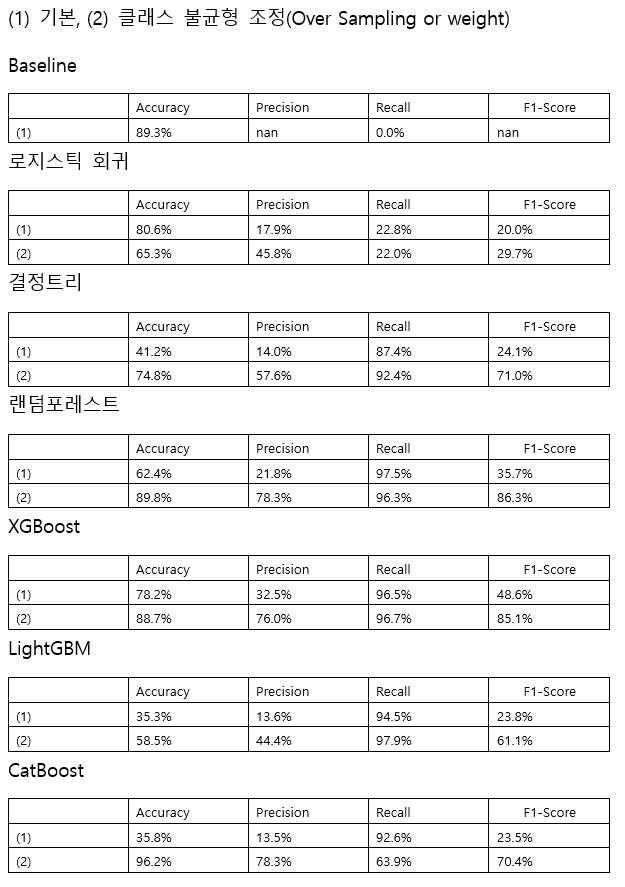

# 4. 결과해석

## 4.1 대출을 상환하지 못한 고객의 특징은 무엇일까?

In [ ]:
class_index = 1
y_pred_proba= xgb_model.predict_proba(X_test)[:, class_index]

In [ ]:
# 예측값과 실제값 비교
df_p = pd.DataFrame({
    'id': test_id, 
    'pred_proba': y_pred_proba, # 예측확률 
    'Target': y_test # 실제값
})

df_p = df_p.merge(
     df[['id', 'issue_d', 'annual_inc', 'inq_last_6mths', 'sub_grade', 'int_rate',
       'installment', 'tot_cur_bal', 'avg_cur_bal', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'num_il_tl',
       'emp_length', 'num_tl_op_past_12m', 'revol_bal', 'total_bc_limit',
       'dti', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'tot_hi_cred_lim', 'home_ownership', 'purpose', 'last_fico_range_high',
       'last_fico_range_low']],
     how='left'
)

In [ ]:
fully_paid = df_p['Target'] == 0
charged_off = ~fully_paid
right = (fully_paid) == (df_p['pred_proba'] > 0.50)
wrong = ~right

In [ ]:
# 대출을 상환하지 못한 샘플들
df_p[charged_off & right].sample(n=10, random_state=1).sort_values(by='pred_proba', ascending=False)

,id,pred_proba,Target,issue_d,annual_inc,inq_last_6mths,sub_grade,int_rate,installment,tot_cur_bal,avg_cur_bal,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_il_tl,emp_length,num_tl_op_past_12m,revol_bal,total_bc_limit,dti,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,tot_hi_cred_lim,home_ownership,purpose,last_fico_range_high,last_fico_range_low
3639,180691,0.483675,1.0,Sep-2020,49000.0,0.0,A1,8.46%,47.33,3700.0,463.0,496.0,8.0,8.0,0.0,7.0,10+ years,3.0,3700.0,20700.0,3.62,1500.00,1500.00,0.00,0.00,0.00,0.00,0.0,50400.0,RENT,credit_card,789.0,785.0
2916,179913,0.303183,1.0,Sep-2020,60000.0,0.0,A4,10.19%,48.54,22411.0,3735.0,71.0,10.0,10.0,0.0,3.0,2 years,3.0,1643.0,14100.0,11.24,1500.00,1500.00,0.00,0.00,0.00,0.00,0.0,43267.0,RENT,debt_consolidation,764.0,760.0
3471,180514,0.241623,1.0,Sep-2020,65000.0,0.0,A3,9.56%,48.10,131594.0,16449.0,117.0,9.0,9.0,1.0,11.0,10+ years,2.0,10319.0,22200.0,15.86,1500.00,1500.00,0.00,0.00,0.00,0.00,0.0,207579.0,MORTGAGE,other,759.0,755.0
2075,179004,0.081920,1.0,May-2020,80000.0,0.0,A1,8.46%,157.75,238541.0,29818.0,238.0,12.0,12.0,3.0,8.0,1 year,1.0,4597.0,26200.0,7.95,4535.03,4535.03,626.30,626.30,464.97,161.33,0.0,306400.0,MORTGAGE,debt_consolidation,734.0,730.0
1998,178920,0.047149,1.0,May-2020,91000.0,0.0,B3,14.71%,945.52,109028.0,6057.0,210.0,15.0,5.0,0.0,16.0,10+ years,1.0,21800.0,142100.0,28.33,38617.63,38617.63,2771.18,2771.18,1382.37,1388.81,0.0,250703.0,RENT,credit_card,744.0,740.0
287,177093,0.043552,1.0,May-2020,72000.0,1.0,C4,19.95%,222.83,308518.0,61704.0,410.0,69.0,4.0,2.0,6.0,3 years,2.0,7094.0,6000.0,19.78,5510.85,5510.85,884.67,884.67,489.15,395.52,0.0,352744.0,MORTGAGE,debt_consolidation,679.0,675.0
312,177119,0.015660,1.0,May-2020,63000.0,0.0,C1,17.30%,179.02,38470.0,3497.0,190.0,31.0,5.0,0.0,9.0,10+ years,1.0,15867.0,9000.0,18.93,4383.89,4383.89,890.29,890.29,616.11,274.18,0.0,44542.0,RENT,vacation,679.0,675.0
1424,178305,0.012972,1.0,May-2020,258000.0,0.0,B5,16.08%,1171.17,498263.0,24913.0,45.0,12.0,7.0,3.0,6.0,1 year,2.0,78458.0,72300.0,24.23,30315.02,30315.02,4625.23,4625.23,2959.98,1665.25,0.0,632589.0,OWN,credit_card,694.0,690.0
3352,180386,0.000833,1.0,Sep-2020,30000.0,0.0,A1,8.46%,283.95,234160.0,33451.0,120.0,77.0,62.0,1.0,4.0,4 years,0.0,500.0,13700.0,7.40,2000.00,2000.00,7000.00,7000.00,7000.00,0.00,0.0,285670.0,RENT,other,834.0,830.0
9835,187400,0.000548,1.0,Sep-2020,98200.0,0.0,A3,9.56%,1052.41,347095.0,24793.0,183.0,14.0,3.0,8.0,22.0,< 1 year,3.0,27297.0,76200.0,22.93,1625.00,1587.87,31200.00,30487.13,31200.00,0.00,0.0,445793.0,MORTGAGE,home_improvement,804.0,800.0


In [ ]:
row = X_test.iloc[[3639]]
row

,id,annual_inc,inq_last_6mths,home_ownership,purpose,last_fico_range_high,last_fico_range_low,sub_grade,int_rate,installment,tot_cur_bal,avg_cur_bal,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_il_tl,emp_length,num_tl_op_past_12m,revol_bal,total_bc_limit,dti,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,tot_hi_cred_lim,issue_d
3639,180691,49000.0,0.0,RENT,credit_card,789.0,785.0,1.1,8.46,47.33,3700.0,463.0,496.0,8.0,8.0,0.0,7.0,10+ years,3.0,3700.0,20700.0,3.62,1500.0,1500.0,0.0,0.0,0.0,0.0,0.0,50400.0,Sep-2020


### SHAP

In [ ]:
row = X_test.iloc[[3639]]
explainer = shap.TreeExplainer(xgb_model.named_steps['xgbclassifier'])
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit',
     
)

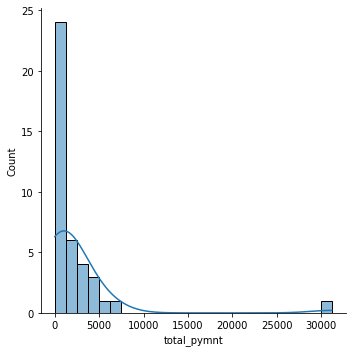

In [ ]:
sns.displot(df_p[charged_off & right].total_pymnt, kde=True);

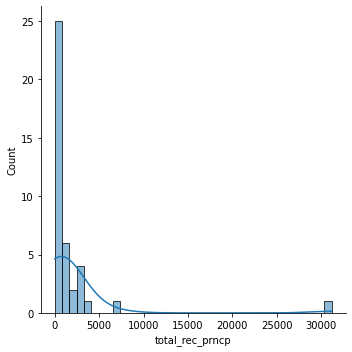

In [ ]:
sns.displot(df_p[charged_off & right].total_rec_prncp, kde=True);

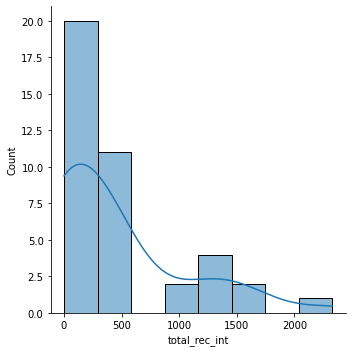

In [ ]:
sns.displot(df_p[charged_off & right].total_rec_int, kde=True);

## 4.2 대출을 상환한 고객들은 어떤 특징이 있을까?


In [ ]:
# 대출을 상환한 샘플들
df_p[fully_paid & right].sample(n=10, random_state=1).sort_values(by='pred_proba', ascending=False)

,id,pred_proba,Target,issue_d,annual_inc,inq_last_6mths,sub_grade,int_rate,installment,tot_cur_bal,avg_cur_bal,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_il_tl,emp_length,num_tl_op_past_12m,revol_bal,total_bc_limit,dti,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,tot_hi_cred_lim,home_ownership,purpose,last_fico_range_high,last_fico_range_low
7519,184886,0.995154,0.0,Sep-2020,210000.0,0.0,A1,8.46%,504.79,552905.0,32524.0,521.0,40.0,13.0,7.0,35.0,3 years,0.0,12276.0,18300.0,15.07,15608.01,15608.01,497.27,497.27,391.99,105.28,0.0,653072.0,MORTGAGE,debt_consolidation,734.0,730.0
11699,189399,0.989503,0.0,Sep-2020,103500.0,0.0,B1,13.33%,1015.60,239827.0,14107.0,204.0,10.0,10.0,3.0,28.0,8 years,2.0,40965.0,33200.0,25.29,29395.41,29395.41,993.38,993.38,604.59,388.79,0.0,271425.0,MORTGAGE,credit_card,719.0,715.0
3684,180737,0.968016,0.0,Sep-2020,88200.0,0.0,C3,19.12%,414.16,42436.0,4715.0,55.0,21.0,21.0,0.0,5.0,5 years,0.0,15942.0,17800.0,18.53,15764.58,15764.58,397.24,397.24,160.42,236.82,0.0,76051.0,RENT,credit_card,709.0,705.0
6722,184036,0.962641,0.0,Sep-2020,160000.0,0.0,A5,10.81%,489.74,48486.0,6927.0,147.0,16.0,5.0,4.0,17.0,1 year,1.0,16095.0,28400.0,12.38,14645.39,14645.39,480.73,480.73,354.61,126.12,0.0,75231.0,RENT,debt_consolidation,689.0,685.0
6060,183315,0.959875,0.0,Sep-2020,365000.0,2.0,C3,19.12%,883.96,84734.0,9415.0,217.0,84.0,6.0,0.0,4.0,6 years,1.0,33829.0,40500.0,12.55,23574.63,23574.63,858.39,858.39,500.37,358.02,0.0,139900.0,RENT,credit_card,719.0,715.0
10075,187663,0.918478,0.0,Sep-2020,70000.0,0.0,A5,10.81%,522.39,51761.0,5176.0,115.0,12.0,12.0,0.0,5.0,9 years,1.0,16051.0,20500.0,29.97,15554.48,15554.48,512.78,512.78,445.52,67.26,0.0,91134.0,OWN,debt_consolidation,729.0,725.0
7813,185206,0.801551,0.0,Sep-2020,50000.0,0.0,B3,14.71%,241.67,26017.0,3252.0,158.0,9.0,9.0,0.0,5.0,3 years,1.0,12179.0,37000.0,24.53,6844.14,6844.14,230.23,230.23,155.86,74.37,0.0,63207.0,RENT,debt_consolidation,689.0,685.0
4150,181251,0.595840,0.0,Sep-2020,69000.0,1.0,C2,18.24%,72.55,71307.0,14261.0,156.0,51.0,10.0,3.0,4.0,10+ years,1.0,850.0,4400.0,6.05,1957.85,1957.85,70.52,70.52,42.15,28.37,0.0,120491.0,MORTGAGE,home_improvement,679.0,675.0
11874,189581,0.564027,0.0,Sep-2020,85000.0,0.0,C1,17.30%,250.62,16056.0,2676.0,151.0,46.0,14.0,0.0,3.0,10+ years,0.0,12342.0,12300.0,7.99,6850.30,6850.30,243.89,243.89,149.70,94.19,0.0,18800.0,RENT,debt_consolidation,674.0,670.0
5845,183080,0.548865,0.0,Sep-2020,48000.0,0.0,C1,17.30%,71.61,31955.0,3196.0,118.0,13.0,7.0,0.0,11.0,10+ years,2.0,6671.0,6900.0,28.33,1936.08,1936.08,67.77,67.77,63.92,3.85,0.0,50407.0,RENT,debt_consolidation,699.0,695.0


In [ ]:
row = X_test.iloc[[7519]]
row

,id,annual_inc,inq_last_6mths,home_ownership,purpose,last_fico_range_high,last_fico_range_low,sub_grade,int_rate,installment,tot_cur_bal,avg_cur_bal,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_il_tl,emp_length,num_tl_op_past_12m,revol_bal,total_bc_limit,dti,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,tot_hi_cred_lim,issue_d
7519,184886,210000.0,0.0,MORTGAGE,debt_consolidation,734.0,730.0,1.1,8.46,504.79,552905.0,32524.0,521.0,40.0,13.0,7.0,35.0,less than 3 years,0.0,12276.0,18300.0,15.07,15608.01,15608.01,497.27,497.27,391.99,105.28,0.0,653072.0,Sep-2020


In [ ]:
row = X_test.iloc[[7519]]
explainer = shap.TreeExplainer(xgb_model.named_steps['xgbclassifier'])
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' 
)

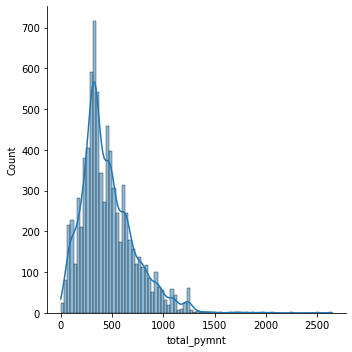

In [ ]:
sns.displot(df_p[fully_paid & right].total_pymnt, kde=True);

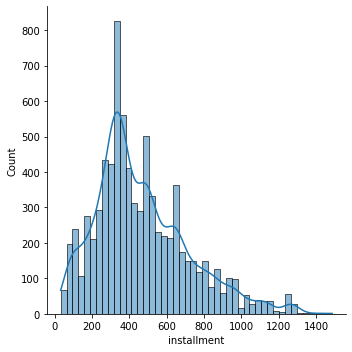

In [ ]:
sns.displot(df_p[fully_paid & right].installment, kde=True);

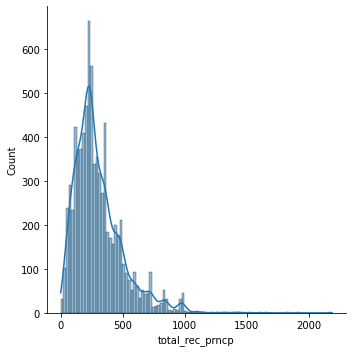

In [ ]:
sns.displot(df_p[fully_paid & right].total_rec_prncp, kde=True);

## 4.3 모델 변수중요도

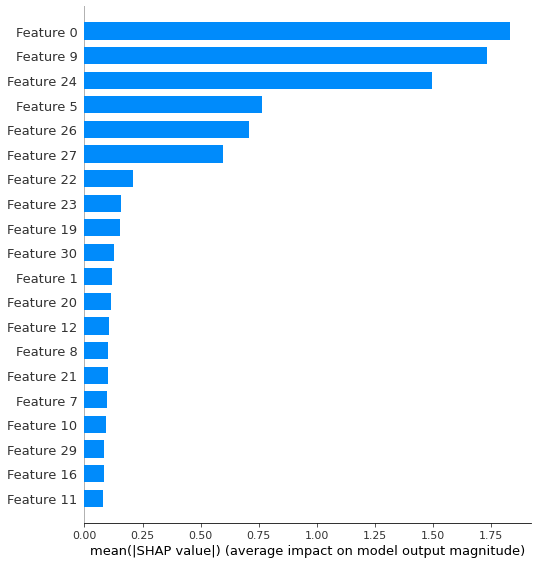

In [ ]:
row_processed = processor.transform(X_test.iloc[:100])

shap.initjs()
shap_values = explainer.shap_values(row_processed)
shap.summary_plot(shap_values, row_processed, plot_type="bar")

- Feature 0: 대출자의 연수입
- Feature 9: 월상환액
- Feature 24: 전체 금액 대비 변제 금액
- Feature 5: 차용자의 마지막 FICO가 속한 하위 경계 범위
- Feature 26: 상환된 총 원금액